In [1]:
# !pip3 install shap
# !pip3 install pyexplainer
# !pip3 install lime
# !pip3 install gensim
# !pip3 install keras
# !pip3 install tensorflow
# !pip3 install sklearn
# !pip3 install nltk
# import nltk
# nltk.download('omw-1.4')
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('stopwords')
# !pip install wordcloud

In [2]:
import numpy as np
import json, re, nltk, string, os, sys
from os.path import abspath
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import wordnet
from gensim.models import Word2Vec
from keras.utils import np_utils
from nltk.corpus import stopwords
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import time

In [3]:
bug_reports = os.path.join(sys.path[0],"data/MozillaCore/train_test_json/classifier_data_20.json")
deep_data = os.path.join(sys.path[0],"data/MozillaCore/deep_data.json")

In [4]:
#========================================================================================
# Initializing Hyper parameter
#========================================================================================
#1. Word2vec parameters
min_word_frequency = 5
embed_size_word2vec = 300
context_window_word2vec = 5

#2. Classifier hyperparameters
numCV = 10
max_sentence_len = 50
min_sentence_length = 15
rankK = 10
batch_size = 32

In [5]:
def contains_letters(phrase):
    return bool(re.search('[a-zA-Z]', phrase))

In [6]:
def getProcessedData(bug_reports):
    with open(bug_reports) as data_file:
        data = json.load(data_file, strict=False)

    i = 0
    
    raw_data = []
    all_data = []
    all_owner = []
    for item in data:
        
        data = 'Title:' + item['issue_title'] + '\n Description: ' + item['description']
        raw_data.append(data) 

        #1. Remove \r
        current_title = item['issue_title'].replace('\r', ' ')
        current_desc = item['description'].replace('\r', ' ')

        #2. Remove URLs
        current_desc = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ', current_desc)

        #3. Remove Stack Trace
        start_loc = current_desc.find("Stack trace:")
        current_desc = current_desc[:start_loc]

        #4. Change to lower case & Remove hex code
        current_data = current_title.lower() + ' ' + current_desc.lower()
        current_data = re.sub(r'(\w+)0x\w+', ' ', current_data)
        current_data = re.sub(r'[^\w\s]', ' ', current_data)
        
        #5. Remove digits
        current_data = re.sub(r'[0-9]', '', current_data)

        #6. Tokenize
        current_data_tokens = [w for w in nltk.word_tokenize(current_data) if contains_letters(w) and len(w) > 1]

        #7. Remove stop words
        stop_words = set(stopwords.words('english'))
        current_data_filter = [w for w in current_data_tokens if not w in stop_words]

        all_data.append(current_data_filter)
        all_owner.append(item['owner'])
        
        i = i + 1
        if i == 35000:
            break

    return raw_data, all_data, all_owner

In [7]:
raw_data, all_data, all_owner = getProcessedData(bug_reports)

In [8]:
len(raw_data)
len(all_data)
len(all_owner)

35000

In [9]:
def getRandomForestClassifierAccuracy(X_train, Y_train, X_test, Y_test):
    start = time.time()

    rfc_model = RandomForestClassifier(n_estimators = 1000, max_depth = 300, n_jobs = -1, random_state=1)
    
    rfc_model.fit(X_train, Y_train) 
    
    y_pred = rfc_model.predict_proba(X_test)
    
    end = time.time()
    
    elapsedTime = end - start
    
    classes = rfc_model.classes_
    sortedIndices = []
    pred_classes = []
    index_pred_classes = []
    rfc_accuracy = []
    index = 0  
    for ll in y_pred:
        sortedIndices.append(sorted(range(len(ll)), key=lambda ii: ll[ii], reverse=True))  
    for k in range(1, rankK+1):
        id = 0
        trueNum = 0
        pred_class_no=0
        for sortedInd in sortedIndices:
            if Y_test[id] in classes[sortedInd[:k]]:
                trueNum += 1
                pred_classes.append(classes[sortedInd[:k]])
                pred_class_no = trueNum
                if index < 9 and k == 1:
                    index = id
                    index_pred_classes.append(classes[sortedInd[:k]])
            id += 1
        rfc_accuracy.append(float('{0:.2f}'.format((float(trueNum) / len(y_pred)) * 100)))

    return rfc_model, rfc_accuracy, classes, index, elapsedTime

In [10]:
def average(lst):
    return sum(lst) / len(lst)

In [11]:
def getRank1_5_10_data(accuracy_cv10_with_avg):
    rank1=''
    rank5=''
    rank10=''
    for i in range(0, 11):
        rank1 = rank1 + str(accuracy_cv10_with_avg[i][0])
        rank5 = rank5 + str(accuracy_cv10_with_avg[i][4])
        rank10 = rank10 + str(accuracy_cv10_with_avg[i][9])

        if i!=10:
            rank1 = rank1 + '  '
            rank5 = rank5 + '  '
            rank10 = rank10 + '  '


    return rank1, rank5, rank10

In [12]:
def getProcessedDeepData(deep_data):
    with open(deep_data) as data_file:
        data = json.load(data_file, strict=False)

    all_data = []
    for item in data:

        #1. Remove \r
        current_title = item['issue_title'].replace('\r', ' ')
        current_desc = item['description'].replace('\r', ' ')

        #2. Remove URLs
        current_desc = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ', current_desc)

        #3. Remove Stack Trace
        start_loc = current_desc.find("Stack trace:")
        current_desc = current_desc[:start_loc]

        #4. Change to lower case & Remove hex code
        current_data = current_title.lower() + ' ' + current_desc.lower()
        current_data = re.sub(r'(\w+)0x\w+', ' ', current_data)
 
        current_data = re.sub(r'[^\w\s]', ' ', current_data)
        
        #5. Remove digits
        current_data = re.sub(r'[0-9]', '', current_data)

        #6. Tokenize
        current_data_tokens = [w for w in nltk.word_tokenize(current_data) if contains_letters(w) and len(w) > 1]

        #7. Remove stop words
        stop_words = set(stopwords.words('english'))
        current_data_filter = [w for w in current_data_tokens if not w in stop_words]

        all_data.append(current_data_filter)

    return all_data

In [13]:
def getSynonyms(word):
    synonyms = []
    synsets = wordnet.synsets(word)
    if (len(synsets) == 0):
        return []
    synset = synsets[0]
    lemma_names = synset.lemma_names()
    for lemma_name in lemma_names:
        lemma_name = lemma_name.lower().replace('_', ' ')
        if (lemma_name != word and lemma_name not in synonyms):
            synonyms.append(lemma_name)
    return set(synonyms)

In [14]:
def makeFeatureVecWithWordNet(bugReport, model, num_features, list_of_syn_data):
    # Function to average all of the word vectors in a given
    # paragraph
    #
    # Pre-initialize an empty numpy array (for speed)
    featureVec = np.zeros((num_features,),dtype="float32")
    #
    nwords = 0
    synCounter = 0
    norCounter = 0
    elseTest = 0
    # 
    # Index2word is a list that contains the names of the words in 
    # the model's vocabulary. Convert it to a set, for speed 
    index2word_set = set(model.wv.index_to_key)
    #
    # Loop over each word in the bugreport and, if it is in the model's
    # vocaublary, add its feature vector to the total
    for word in bugReport:
        found = False
        if word in index2word_set: 
            norCounter = norCounter+1
            nwords = nwords + 1
            featureVec = np.add(featureVec,model.wv[word])
            if nwords == max_sentence_len-1:
                break
        else:
            elseTest = elseTest + 1
            for synonym in getSynonyms(word):
                if synonym in index2word_set:
                    list_of_syn_data.append(word + ' : ' + synonym)
                    synCounter = synCounter + 1
                    nwords = nwords + 1
                    featureVec = np.add(featureVec, model.wv[synonym])
                    found = True
                    break
            if nwords == max_sentence_len-1:
                break
    # 
    # Divide the result by the number of words to get the average
    featureVec = np.divide(featureVec,nwords)
    return elseTest, synCounter, norCounter, featureVec


def getAvgFeatureVecsWithWordNet(bugReports, model, num_features):
    # Given a set of reviews (each one a list of words), calculate 
    # the average feature vector for each one and return a 2D numpy array 
    # 
    # Initialize a counter
    counter = 0
    synonymCounter = 0
    normalCounter = 0
    elseTest1=0
    list_of_syn_data = []
    # 
    # Preallocate a 2D numpy array, for speed
    bugReportsVecs = np.zeros((len(bugReports),num_features),dtype="float32")
    # 
    # Loop through the reviews
    for bugReport in bugReports:
        # Call the function (defined above) that makes average feature vectors
        elseTest, synCounter, norCounter, bugReportsVecs[counter] = makeFeatureVecWithWordNet(
            bugReport, model, num_features, list_of_syn_data)
        
        synonymCounter = synonymCounter + synCounter 
        normalCounter = normalCounter + norCounter
        elseTest1 = elseTest1 + elseTest
        #
        # Increment the counter
        counter = counter + 1
        
    print('elseTest1,', elseTest1)
#     print('list_of_syn_data,', list_of_syn_data)
    return synonymCounter, normalCounter, bugReportsVecs


In [15]:
def makeFeatureVec(bugReport, model, num_features):
    # Function to average all of the word vectors in a given
    # paragraph
    #
    # Pre-initialize an empty numpy array (for speed)
    featureVec = np.zeros((num_features,),dtype="float32")
    #
    nwords = 0.
    # 
    # Index2word is a list that contains the names of the words in 
    # the model's vocabulary. Convert it to a set, for speed 
    index2word_set = set(model.wv.index_to_key)
    #
    # Loop over each word in the bugreport and, if it is in the model's
    # vocaublary, add its feature vector to the total
    for word in bugReport:
        found = False
        if word in index2word_set: 
            nwords = nwords + 1.
            featureVec = np.add(featureVec,model.wv[word])
            if nwords == max_sentence_len-1:
                break
    # 
    # Divide the result by the number of words to get the average
    featureVec = np.divide(featureVec,nwords)
    return featureVec


def getAvgFeatureVecs(bugReports, model, num_features):
    # Given a set of reviews (each one a list of words), calculate 
    # the average feature vector for each one and return a 2D numpy array 
    # 
    # Initialize a counter
    counter = 0
    # 
    # Preallocate a 2D numpy array, for speed
    bugReportsVecs = np.zeros((len(bugReports),num_features),dtype="float32")
    # 
    # Loop through the bugreport
    for bugReport in bugReports:
        # Call the function (defined above) that makes average feature vectors
        bugReportsVecs[counter] = makeFeatureVec(bugReport, model, num_features)
        #
        # Increment the counter
        counter = counter + 1
    return bugReportsVecs

In [16]:
deep_data_list = getProcessedDeepData(deep_data)

In [17]:
def getFilteredDataForWordnet(train_data, test_data, vocabulary):
    updated_raw_train_data = []
    updated_raw_test_data = []
    updated_train_data = []
    updated_train_owner = []
    final_raw_test_data = []
    final_test_data = []
    final_test_owner = []
    train_word_count = 0
    test_word_count = 0
    updated_train_word_count = 0
    updated_test_word_count = 0
    
    for j, item in enumerate(train_data):
        train_word_count = train_word_count + len(item)
        current_train_filter = [word for word in item if word in vocabulary or set(getSynonyms(word)).intersection(vocabulary)]
        updated_train_word_count = updated_train_word_count + len(current_train_filter)
        if len(current_train_filter)>=min_sentence_length:
            updated_train_data.append(current_train_filter)
            updated_train_owner.append(train_owner[j])
            updated_raw_train_data.append(raw_train_data[j])

    for j, item in enumerate(test_data):
        test_word_count = test_word_count + len(item)
        current_test_filter = [word for word in item if word in vocabulary or set(getSynonyms(word)).intersection(vocabulary)]
        updated_test_word_count = updated_test_word_count + len(current_test_filter)
        if len(current_test_filter)>=min_sentence_length:
            final_test_data.append(current_test_filter)
            final_test_owner.append(test_owner[j])
            final_raw_test_data.append(raw_test_data[j])
            
    # Remove data from test set that is not there in train set
    train_owner_unique = set(updated_train_owner)
    test_owner_unique = set(final_test_owner)
    unwanted_owner = list(test_owner_unique - train_owner_unique)
    updated_raw_test_data = []
    updated_test_data = []
    updated_test_owner = []
    for j in range(len(final_test_owner)):
        if final_test_owner[j] not in unwanted_owner:
            updated_test_data.append(final_test_data[j])
            updated_test_owner.append(final_test_owner[j])
            updated_raw_test_data.append(final_raw_test_data[j])

    unique_train_label = list(set(updated_train_owner))
    
    return updated_raw_train_data, updated_train_data, updated_train_owner, updated_raw_test_data, updated_test_data, updated_test_owner, train_word_count, test_word_count, updated_train_word_count, updated_test_word_count


In [18]:
def getFilteredData(train_data, test_data, vocabulary):
    updated_raw_train_data = []
    updated_raw_test_data = []
    updated_train_data = []
    updated_train_owner = []
    final_raw_test_data = []
    final_test_data = []
    final_test_owner = []
    train_word_count = 0
    test_word_count = 0
    updated_train_word_count = 0
    updated_test_word_count = 0
    
    for j, item in enumerate(train_data): 
        train_word_count = train_word_count + len(item)
        current_train_filter = [word for word in item if word in vocabulary]
        updated_train_word_count = updated_train_word_count + len(current_train_filter)
        if len(current_train_filter)>=min_sentence_length:
            updated_train_data.append(current_train_filter)
            updated_train_owner.append(train_owner[j])
            updated_raw_train_data.append(raw_train_data[j])

    for j, item in enumerate(test_data):
        test_word_count = test_word_count + len(item)
        current_test_filter = [word for word in item if word in vocabulary]
        updated_test_word_count = updated_test_word_count + len(current_test_filter)
        if len(current_test_filter)>=min_sentence_length:
            final_test_data.append(current_test_filter)
            final_test_owner.append(test_owner[j])
            final_raw_test_data.append(raw_test_data[j])
            
    # Remove data from test set that is not there in train set
    train_owner_unique = set(updated_train_owner)
    test_owner_unique = set(final_test_owner)
    unwanted_owner = list(test_owner_unique - train_owner_unique)
    updated_raw_test_data = []
    updated_test_data = []
    updated_test_owner = []
    for j in range(len(final_test_owner)):
        if final_test_owner[j] not in unwanted_owner:
            updated_test_data.append(final_test_data[j])
            updated_test_owner.append(final_test_owner[j])
            updated_raw_test_data.append(final_raw_test_data[j])

    unique_train_label = list(set(updated_train_owner))
    
    return updated_raw_train_data, updated_train_data, updated_train_owner, updated_raw_test_data, updated_test_data, updated_test_owner, train_word_count, test_word_count, updated_train_word_count, updated_test_word_count

In [19]:
totalLength = len(all_data)
trainingTestingLength = totalLength / (numCV + 1)

rfc_accuracy_cv10 = []
m_accuracy_cv10 = []
nn_accuracy_cv10 = []
rfc_accuracy_with_wordnet_cv10 = []
m_accuracy_with_wordnet_cv10 = []
nn_accuracy_with_wordnet_cv10 = []
rfc_with_wordnet_elapsed_time_cv10 = []
mlp_with_wordnet_elapsed_time_cv10 = []
rfc_elapsed_time_cv10 = []
mlp_elapsed_time_cv10 = []
nn_elapsed_time_cv10 = []

train_word_count_for_wordnet = []
updated_train_word_count_for_wordnet = []
test_word_count_for_wordnet = []
updated_test_word_count_for_wordnet = []
synonymCounter_training_for_wordnet = []
normalCounter_training_for_wordnet = []
synonymCounter_test_for_wordnet = []
normalCounter_test_for_wordnet = []

train_word_count_without_wordnet = []
updated_train_word_count_without_wordnet = []
test_word_count_without_wordnet = []
updated_test_word_count_without_wordnet = []


for i in range(1, numCV+1):
    # Split cross validation set
    print(i)
    raw_train_data = raw_data[:int(i*trainingTestingLength)]
    raw_test_data = raw_data[int(i*trainingTestingLength):int((i+1)*trainingTestingLength)]
    train_data = all_data[:int(i*trainingTestingLength)]
    test_data = all_data[int(i*trainingTestingLength):int((i+1)*trainingTestingLength)]
    train_owner = all_owner[:int(i*trainingTestingLength)]
    test_owner = all_owner[int(i*trainingTestingLength):int((i+1)*trainingTestingLength)]
    
    print(len(raw_train_data))
    print(len(raw_test_data))
    print(len(train_data))
    print(len(test_data))
    print(len(train_owner))
    print(len(test_owner))
    
    data_for_word_2_vec = deep_data_list + train_data
    
    print(len(data_for_word_2_vec))
    
    wordvec_model = Word2Vec(data_for_word_2_vec, min_count=min_word_frequency, vector_size=embed_size_word2vec, window=context_window_word2vec)
    vocabulary = set(wordvec_model.wv.index_to_key)
    vocab_size = len(vocabulary)
    
    print(vocab_size)
    
    
    updated_raw_train_data, updated_train_data, updated_train_owner, updated_raw_test_data, updated_test_data, updated_test_owner, train_word_count, test_word_count, updated_train_word_count, updated_test_word_count = getFilteredDataForWordnet(train_data, test_data, vocabulary)
    
    synonymCounter_training = 0
    normalCounter_training = 0
    
    synonymCounter_training, normalCounter_training, X_matrix_train = getAvgFeatureVecsWithWordNet(updated_train_data, wordvec_model, embed_size_word2vec)
    
    print('with wordnet')
    print('train_word_count : ', train_word_count)
    print('updated_train_word_count : ', updated_train_word_count)
    print('removed_train_word_count : ', train_word_count - updated_train_word_count)
    print('synonymCounter_training : ', synonymCounter_training)
    print('normalCounter_training : ', normalCounter_training)
    
    synonymCounter_testing = 0
    normalCounter_testing = 0
    
    synonymCounter_testing, normalCounter_testing, X_matrix_test = getAvgFeatureVecsWithWordNet(updated_test_data, wordvec_model, embed_size_word2vec)
    
    print('test_word_count : ', test_word_count)
    print('updated_test_word_count : ', updated_test_word_count)
    print('removed_test_word_count : ', test_word_count - updated_test_word_count)
    print('synonymCounter_testing : ', synonymCounter_testing)
    print('normalCounter_testing : ', normalCounter_testing)
    
    train_word_count_for_wordnet.append(train_word_count)
    updated_train_word_count_for_wordnet.append(updated_train_word_count)
    test_word_count_for_wordnet.append(test_word_count)
    updated_test_word_count_for_wordnet.append(updated_test_word_count)
    synonymCounter_training_for_wordnet.append(synonymCounter_training)
    normalCounter_training_for_wordnet.append(normalCounter_training)
    synonymCounter_test_for_wordnet.append(synonymCounter_testing)
    normalCounter_test_for_wordnet.append(normalCounter_testing)
    
    
    randomForestClassifier, rfc_accuracy_with_wordnet, classes, rfc_index_with_wordnet_cv10, rfc_with_wordnet_elapsed_time = getRandomForestClassifierAccuracy(X_matrix_train, updated_train_owner, 
                                                                      X_matrix_test, updated_test_owner)
    

    print('Random Forest Classifier Accuracy(With Wordnet) : ', rfc_accuracy_with_wordnet)
    
    del randomForestClassifier
    
    updated_raw_train_data, updated_train_data, updated_train_owner, updated_raw_test_data, updated_test_data, updated_test_owner, train_word_count, test_word_count, updated_train_word_count, updated_test_word_count = getFilteredData(train_data, test_data, vocabulary)
    
    X_matrix_train = getAvgFeatureVecs(updated_train_data, wordvec_model, embed_size_word2vec)
    X_matrix_test = getAvgFeatureVecs(updated_test_data, wordvec_model, embed_size_word2vec)
    
    print('without wordnet')
    print('train_word_count : ', train_word_count)
    print('updated_train_word_count : ', updated_train_word_count)
    print('removed_train_word_count : ', train_word_count - updated_train_word_count)
    print('test_word_count : ', test_word_count)
    print('updated_test_word_count : ', updated_test_word_count)
    print('removed_test_word_count : ', test_word_count - updated_test_word_count)
    
    train_word_count_without_wordnet.append(train_word_count)
    updated_train_word_count_without_wordnet.append(updated_train_word_count)
    test_word_count_without_wordnet.append(test_word_count)
    updated_test_word_count_without_wordnet.append(updated_test_word_count)
    
    
    randomForestClassifier, rfc_accuracy, classes, rfc_index_cv10, rfc_elapsed_time = getRandomForestClassifierAccuracy(X_matrix_train, 
                                                                              updated_train_owner, 
                                                                              X_matrix_test, 
                                                                              updated_test_owner)
    

    print('Random Forest Classifier Accuracy : ', rfc_accuracy)

    del randomForestClassifier
    
    rfc_accuracy_cv10.append(rfc_accuracy)
    rfc_accuracy_with_wordnet_cv10.append(rfc_accuracy_with_wordnet)
    
    
    rfc_with_wordnet_elapsed_time_cv10.append(rfc_with_wordnet_elapsed_time)
    rfc_elapsed_time_cv10.append(rfc_elapsed_time)
    

1
3181
3182
3181
3182
3181
3182
189354
73229
elseTest1, 117
with wordnet
train_word_count :  219089
updated_train_word_count :  213774
removed_train_word_count :  5315
synonymCounter_training :  117
normalCounter_training :  108051
elseTest1, 84
test_word_count :  226746
updated_test_word_count :  220245
removed_test_word_count :  6501
synonymCounter_testing :  84
normalCounter_testing :  108336
Random Forest Classifier Accuracy(With Wordnet) :  [13.89, 22.39, 27.79, 33.32, 38.0, 41.64, 45.5, 48.07, 50.79, 52.89]
without wordnet
train_word_count :  219089
updated_train_word_count :  213579
removed_train_word_count :  5510
test_word_count :  226746
updated_test_word_count :  220096
removed_test_word_count :  6650
Random Forest Classifier Accuracy :  [13.65, 22.4, 28.01, 33.23, 38.05, 41.66, 44.59, 47.66, 50.3, 52.52]
2
6363
3182
6363
3182
6363
3182
192536
73836
elseTest1, 194
with wordnet
train_word_count :  445835
updated_train_word_count :  436356
removed_train_word_count :  9479
syno

Random Forest Classifier Accuracy :  [15.15, 21.66, 26.57, 30.48, 33.95, 35.86, 37.85, 40.13, 41.72, 43.09]


In [20]:
print('train_word_count_for_wordnet: ', train_word_count_for_wordnet)
print('updated_train_word_count_for_wordnet: ', updated_train_word_count_for_wordnet)
print('test_word_count_for_wordnet: ', test_word_count_for_wordnet)
print('updated_test_word_count_for_wordnet: ', updated_test_word_count_for_wordnet)
print('synonymCounter_training_for_wordnet: ', synonymCounter_training_for_wordnet)
print('normalCounter_training_for_wordnet: ', normalCounter_training_for_wordnet)
print('synonymCounter_test_for_wordnet: ', synonymCounter_test_for_wordnet)
print('normalCounter_test_for_wordnet: ', normalCounter_test_for_wordnet)

print('train_word_count_without_wordnet: ',train_word_count_without_wordnet)
print('updated_train_word_count_without_wordnet: ', updated_train_word_count_without_wordnet)
print('test_word_count_without_wordnet: ',test_word_count_without_wordnet)
print('updated_test_word_count_without_wordnet: ', updated_test_word_count_without_wordnet)

train_word_count_for_wordnet:  [219089, 445835, 664971, 897130, 1097561, 1318148, 1543830, 1783880, 2025834, 2276965]
updated_train_word_count_for_wordnet:  [213774, 436356, 651751, 879998, 1076318, 1292634, 1513627, 1749250, 1986449, 2233042]
test_word_count_for_wordnet:  [226746, 219136, 232159, 200431, 220587, 225682, 240050, 241954, 251131, 241093]
updated_test_word_count_for_wordnet:  [220245, 213389, 225844, 194402, 213848, 218302, 233094, 234888, 244594, 235142]
synonymCounter_training_for_wordnet:  [117, 194, 269, 355, 431, 514, 588, 670, 735, 779]
normalCounter_training_for_wordnet:  [108051, 219097, 333025, 452248, 563208, 677267, 788413, 904377, 1020593, 1131747]
synonymCounter_test_for_wordnet:  [84, 102, 125, 97, 110, 113, 110, 97, 79, 70]
normalCounter_test_for_wordnet:  [108336, 111322, 116425, 108722, 112193, 109792, 114300, 114414, 108348, 108906]
train_word_count_without_wordnet:  [219089, 445835, 664971, 897130, 1097561, 1318148, 1543830, 1783880, 2025834, 2276965]
u

In [21]:
print(rfc_accuracy_cv10)

[[13.65, 22.4, 28.01, 33.23, 38.05, 41.66, 44.59, 47.66, 50.3, 52.52], [17.86, 27.41, 34.02, 39.49, 43.79, 47.59, 50.28, 52.59, 54.97, 57.24], [15.54, 23.89, 29.23, 33.54, 37.61, 40.31, 43.09, 45.55, 47.5, 49.04], [14.28, 22.63, 28.49, 32.56, 35.45, 38.31, 40.99, 43.41, 44.88, 46.34], [17.01, 25.42, 31.38, 35.41, 38.22, 40.85, 43.16, 45.13, 46.98, 48.39], [14.41, 21.55, 25.79, 29.4, 32.14, 34.82, 37.25, 38.82, 40.71, 43.03], [13.8, 19.96, 24.8, 28.72, 32.05, 34.57, 36.95, 39.09, 41.4, 42.63], [11.0, 16.17, 21.31, 24.65, 28.31, 31.37, 34.35, 37.01, 38.81, 40.68], [12.23, 19.63, 25.69, 29.58, 33.02, 36.09, 37.92, 40.31, 42.0, 43.72], [15.15, 21.66, 26.57, 30.48, 33.95, 35.86, 37.85, 40.13, 41.72, 43.09]]


In [22]:
rfc_accuracy_cv10_with_avg = rfc_accuracy_cv10

In [23]:
print(rfc_accuracy_with_wordnet_cv10)

[[13.89, 22.39, 27.79, 33.32, 38.0, 41.64, 45.5, 48.07, 50.79, 52.89], [17.72, 26.7, 33.98, 39.67, 44.14, 47.55, 50.64, 52.91, 54.79, 56.96], [15.81, 23.85, 29.35, 34.14, 37.56, 40.61, 43.0, 45.36, 47.66, 49.54], [14.63, 23.01, 27.76, 31.97, 35.11, 37.92, 40.17, 42.74, 44.74, 46.24], [16.61, 25.27, 30.53, 34.49, 37.47, 39.92, 42.55, 44.51, 46.51, 48.16], [14.41, 20.98, 25.94, 28.86, 32.0, 34.82, 36.75, 38.92, 40.99, 42.95], [13.87, 20.2, 25.18, 29.2, 32.35, 35.01, 37.29, 39.04, 41.42, 43.03], [10.81, 16.56, 20.94, 24.5, 28.56, 31.82, 33.76, 35.81, 38.11, 39.83], [11.78, 19.67, 25.17, 29.58, 32.98, 35.34, 37.85, 40.05, 42.03, 43.42], [14.82, 21.98, 27.51, 31.06, 33.48, 36.08, 38.47, 40.35, 42.01, 43.56]]


In [24]:
rfc_accuracy_with_wordnet_cv10_with_avg = rfc_accuracy_with_wordnet_cv10

In [25]:
rfc_accuracy_avg = [float('{0:.2f}'.format(float(sum(l))/len(l))) for l in zip(*rfc_accuracy_cv10)]
rfc_accuracy_with_wordnet_avg = [float('{0:.2f}'.format(float(sum(l))/len(l))) for l in zip(*rfc_accuracy_with_wordnet_cv10)]

In [26]:
print(rfc_accuracy_avg)

[14.49, 22.07, 27.53, 31.71, 35.26, 38.14, 40.64, 42.97, 44.93, 46.67]


In [27]:
print(rfc_accuracy_with_wordnet_avg)

[14.43, 22.06, 27.42, 31.68, 35.17, 38.07, 40.6, 42.78, 44.91, 46.66]


In [28]:
rfc_accuracy_cv10_with_avg.append(rfc_accuracy_avg)

In [29]:
rfc_accuracy_with_wordnet_cv10_with_avg.append(rfc_accuracy_with_wordnet_avg)

In [30]:
rfc_accuracy_cv10_with_avg_rank1, rfc_accuracy_cv10_with_avg_rank5, rfc_accuracy_cv10_with_avg_rank10 = getRank1_5_10_data(rfc_accuracy_cv10_with_avg)         
    
print(rfc_accuracy_cv10_with_avg_rank1)
print(rfc_accuracy_cv10_with_avg_rank5)
print(rfc_accuracy_cv10_with_avg_rank10)

13.65  17.86  15.54  14.28  17.01  14.41  13.8  11.0  12.23  15.15  14.49
38.05  43.79  37.61  35.45  38.22  32.14  32.05  28.31  33.02  33.95  35.26
52.52  57.24  49.04  46.34  48.39  43.03  42.63  40.68  43.72  43.09  46.67


In [31]:
print(rfc_accuracy_cv10_with_avg_rank1)
print(rfc_accuracy_cv10_with_avg_rank5)
print(rfc_accuracy_cv10_with_avg_rank10)

13.65  17.86  15.54  14.28  17.01  14.41  13.8  11.0  12.23  15.15  14.49
38.05  43.79  37.61  35.45  38.22  32.14  32.05  28.31  33.02  33.95  35.26
52.52  57.24  49.04  46.34  48.39  43.03  42.63  40.68  43.72  43.09  46.67


In [32]:
rfc_accuracy_with_wordnet_cv10_with_avg_rank1, rfc_accuracy_with_wordnet_cv10_with_avg_rank5, rfc_accuracy_with_wordnet_cv10_with_avg_rank10 = getRank1_5_10_data(rfc_accuracy_with_wordnet_cv10_with_avg)         
    
print(rfc_accuracy_with_wordnet_cv10_with_avg_rank1)
print(rfc_accuracy_with_wordnet_cv10_with_avg_rank5)
print(rfc_accuracy_with_wordnet_cv10_with_avg_rank10)

13.89  17.72  15.81  14.63  16.61  14.41  13.87  10.81  11.78  14.82  14.43
38.0  44.14  37.56  35.11  37.47  32.0  32.35  28.56  32.98  33.48  35.17
52.89  56.96  49.54  46.24  48.16  42.95  43.03  39.83  43.42  43.56  46.66


In [33]:
rfc_with_wordnet_elapsed_time_cv10

[12.417125225067139,
 32.98961091041565,
 59.76059579849243,
 102.79658007621765,
 143.92229413986206,
 191.65159511566162,
 251.03402304649353,
 301.61003279685974,
 358.9955208301544,
 427.446270942688]

In [34]:
print(np.mean(rfc_with_wordnet_elapsed_time_cv10))

188.26236488819123


In [35]:
rfc_elapsed_time_cv10

[11.774103164672852,
 33.103240966796875,
 59.983924865722656,
 100.78099298477173,
 142.5953769683838,
 189.5070149898529,
 251.4755880832672,
 300.1940047740936,
 356.40717482566833,
 427.16994881629944]

In [36]:
print(np.mean(rfc_elapsed_time_cv10))

187.29913704395295


In [37]:
print(rfc_accuracy_avg)

[14.49, 22.07, 27.53, 31.71, 35.26, 38.14, 40.64, 42.97, 44.93, 46.67]


In [38]:
print(rfc_accuracy_with_wordnet_avg)

[14.43, 22.06, 27.42, 31.68, 35.17, 38.07, 40.6, 42.78, 44.91, 46.66]


In [39]:
rfc_accuracy_avg = [14.49, 22.07, 27.53, 31.71, 35.26, 38.14, 40.64, 42.97, 44.93, 46.67]
rfc_accuracy_with_wordnet_avg = [14.43, 22.06, 27.42, 31.68, 35.17, 38.07, 40.6, 42.78, 44.91, 46.66]

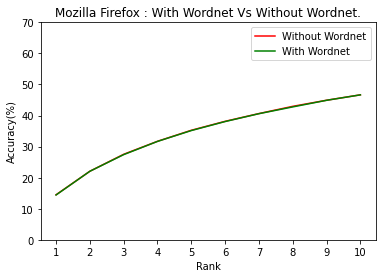

In [40]:
# x = range(1,12)
y = range(0,70)

plt.plot(rfc_accuracy_avg, color='red',label ='Without Wordnet')
plt.plot(rfc_accuracy_with_wordnet_avg, color='green',label ='With Wordnet')
plt.title('Mozilla Core : With Wordnet Vs Without Wordnet.')
plt.xlabel('Rank')
plt.ylabel('Accuracy(%)')
plt.xticks([r for r in range(10)],
        ['1', '2', '3', '4', '5','6', '7', '8', '9', '10'])
plt.yticks(np.arange(0, 80, 10))
plt.legend()
# plt.show()

plt.savefig('rf_word2vec_mc_with_or_without_wordnet.png')

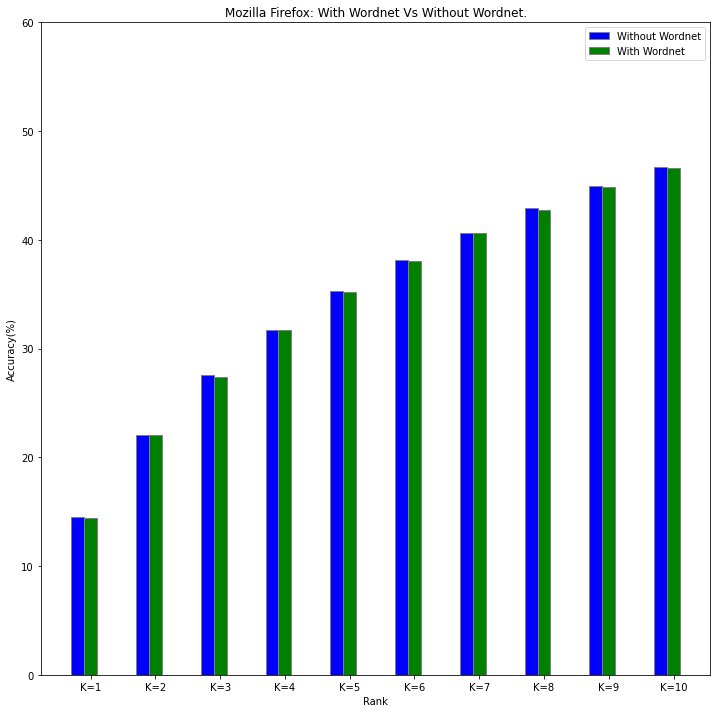

In [41]:
y = range(0,70)
# set width of bar
barWidth = 0.20
fig = plt.subplots(figsize =(12, 12))
 
# Set position of bar on X axis
br1 = np.arange(10)
br2 = [x + barWidth for x in br1]

# Make the plot
plt.bar(br1, rfc_accuracy_avg, color ='b', width = barWidth,
        edgecolor ='grey', label ='Without Wordnet')
plt.bar(br2, rfc_accuracy_with_wordnet_avg, color ='g', width = barWidth,
        edgecolor ='grey', label ='With Wordnet')
 
# Adding Xticks
plt.xlabel('Rank')
plt.ylabel('Accuracy(%)')
plt.xticks([r + barWidth for r in range(10)],
       ['K=1', 'K=2', 'K=3', 'K=4', 'K=5', 'K=6', 'K=7', 'K=8', 'K=9', 'K=10'])
plt.yticks(np.arange(0, 70, 10))

plt.title('Mozilla Core: With Wordnet Vs Without Wordnet.')
 
plt.legend()

# plt.show()

plt.savefig('mc_rf_with_or_without_wordnet.png')

In [42]:
rfc_accuracy_avg_rank = []
rfc_accuracy_with_wordnet_avg_rank = []

rfc_accuracy_avg_rank.append(rfc_accuracy_avg[0])
rfc_accuracy_avg_rank.append(rfc_accuracy_avg[4])
rfc_accuracy_avg_rank.append(rfc_accuracy_avg[9])

rfc_accuracy_with_wordnet_avg_rank.append(rfc_accuracy_with_wordnet_avg[0])
rfc_accuracy_with_wordnet_avg_rank.append(rfc_accuracy_with_wordnet_avg[4])
rfc_accuracy_with_wordnet_avg_rank.append(rfc_accuracy_with_wordnet_avg[9])

In [43]:
print(rfc_accuracy_avg_rank)
print(rfc_accuracy_with_wordnet_avg_rank)

[14.49, 35.26, 46.67]
[14.43, 35.17, 46.66]


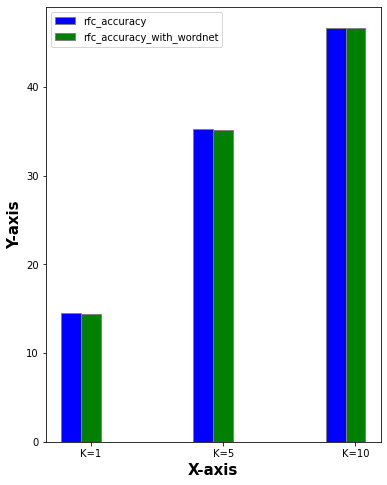

In [44]:
# set width of bar
barWidth = 0.15
fig = plt.subplots(figsize =(6, 8))
 
# Set position of bar on X axis
br1 = np.arange(3)
br2 = [x + barWidth for x in br1]


# Make the plot
plt.bar(br1, rfc_accuracy_avg_rank, color ='b', width = barWidth,
        edgecolor ='grey', label ='rfc_accuracy')
plt.bar(br2, rfc_accuracy_with_wordnet_avg_rank, color ='g', width = barWidth,
        edgecolor ='grey', label ='rfc_accuracy_with_wordnet')
 
# Adding Xticks
plt.xlabel('X-axis', fontweight ='bold', fontsize = 15)
plt.ylabel('Y-axis', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(3)],
        ['K=1', 'K=5', 'K=10'])

# plt.title('Accuracy with or without wordnet (Rank 1, 5 and 10): BiDirectional Neural Network')
 
plt.legend()

# plt.show()

plt.savefig('Accuracy_Random_Forest_with_or_without_wordnet_bar_rank_mc.png')